# 0.0 Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import datetime as dt
import re
import warnings

from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import calinski_harabasz_score,davies_bouldin_score
from sklearn.preprocessing import normalize
from sklearn import metrics as m
import umap.umap_ as umap

from plotly import express as px

from IPython.display import Image
from IPython.core.display import HTML
warnings.filterwarnings('ignore')

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## 0.1 Helper Function

In [2]:
 def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def hyperparameter_tunning(model, clusters,data):
    # wss
    wss = kmeans = KElbowVisualizer(c.KMeans(),k=clusters,
                         timings=False )
    wss.fit(data)
    # ss 
    ss = KElbowVisualizer(c.KMeans(),
                         k=clusters,
                         metric='silhouette',
                         timings=False)
    ss.fit(data)
    df = pd.DataFrame({'Metric': ['WSS','SS'], 'Score':[wss.elbow_score_.round(2),ss.elbow_score_.round(2)],
                       'Recomended k':[wss.elbow_value_,ss.elbow_value_]})
    return df
   

Populating the interactive namespace from numpy and matplotlib


# 0.2 Loading Data

In [3]:
df = pd.read_csv('../data/raw/Ecommerce.csv',encoding= 'unicode_escape')
df.drop('Unnamed: 8', axis=1,inplace=True)

# 1.0 Data Description

In [4]:
df1 = df.copy()

* Invoice Number: identificador único de cada transação.
* Stock Code Product: código do item.
* Description Product: nome do item
* Quantity: A quantidade de cada item comprado por transação.
* Invoice Date: O dia em que a transação ocorreu
* Unit Price: Preço do produto por unidade
* Customer ID: identificador único do cliente
* Country: O nome do país que o cliente resid

In [5]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1 Rename columns

In [6]:
old_cols = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))

# Rename columns
df1.columns = new_cols

## 1.2 Data Dimension

In [7]:
print('Number of row: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of row: 541909
Number of columns: 8


## 1.3 Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NAs

In [9]:
df1.isna().sum()[df1.isna().sum()>0]

description      1454
customer_id    135080
dtype: int64

## 1.5 Replace NAs

At this first, we'll simply remove the NAs.

In [10]:
# remove NAs
df1.dropna(subset=['description','customer_id'], inplace=True)
print('Percentage of Removed Values: {:.2f}'.format(1-(df1.shape[0]/df.shape[0])))

Percentage of Removed Values: 0.25


In [11]:
# Check NAs again 
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change data types

In [12]:
# invoice date
df1['invoice_date'] =  pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype( int )

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.7 Descriptive Statistics

Let's leave this step to the next CRISP cycles.

# 2.0 Feature Engeneering

In [14]:
df2 = df1.copy()

## 2.1 Data Wragling

In [15]:
# Identifying customers with zero quantity in total
total_quantity = df2[['quantity','customer_id']].groupby('customer_id').sum()
customers_zero_quantity = total_quantity[total_quantity.quantity==0].index.to_list()

In [16]:
# Identifying all chargeback transactions - they all have negativa quantities
chargeback = df2[df2['invoice_no'].str.contains("[A-Z]")]
chargeback.shape

(8905, 8)

However, for the interests of the model, we do not need to worry about the chargebacks' negative quantities. because they will cancel out with their positive quantities once we sum up all the quantities for each customer.

We'll only drop the clients with zero quantitiesm in the cell below.

## 2.2 Feature Creation

In [17]:
# Data reference
df_ref = df2[['customer_id']].drop_duplicates().reset_index()
df_ref.drop('index',axis=1, inplace=True)

# Drop customers with zero quantity in total
df_ref = df_ref[~df_ref.customer_id.isin(customers_zero_quantity )]

# Gross Revenue (faturamento)
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref  =pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last Day purchase
df_recency = df2[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id',how='left')

# Frequency
df_freq =df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id',how='left')

# Average Ticket
df_avg_ticket = df2[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id',how='left')

# Drop customer with 0 gross revenue
df_ref = df_ref[df_ref.gross_revenue!=0]

df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


# 3.0 Feature Filtering

In [18]:
df3 =df_ref.copy()

# 4.0 Exploratory Data Analysis

In [19]:
df4 = df3.copy()

# 5.0 Data Preparation

In [20]:
df5 = df4.copy()

# 6.0 Feature Selection

In [21]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

This step servers for testing how many clusters fits the model the best.

In [22]:
X = df6.drop('customer_id',axis=1)

In [23]:
# Listing possible values for k
clusters =[2,3,4,5,6,7]


## 7.1 Within-Cluster Sum of Square (WSS)

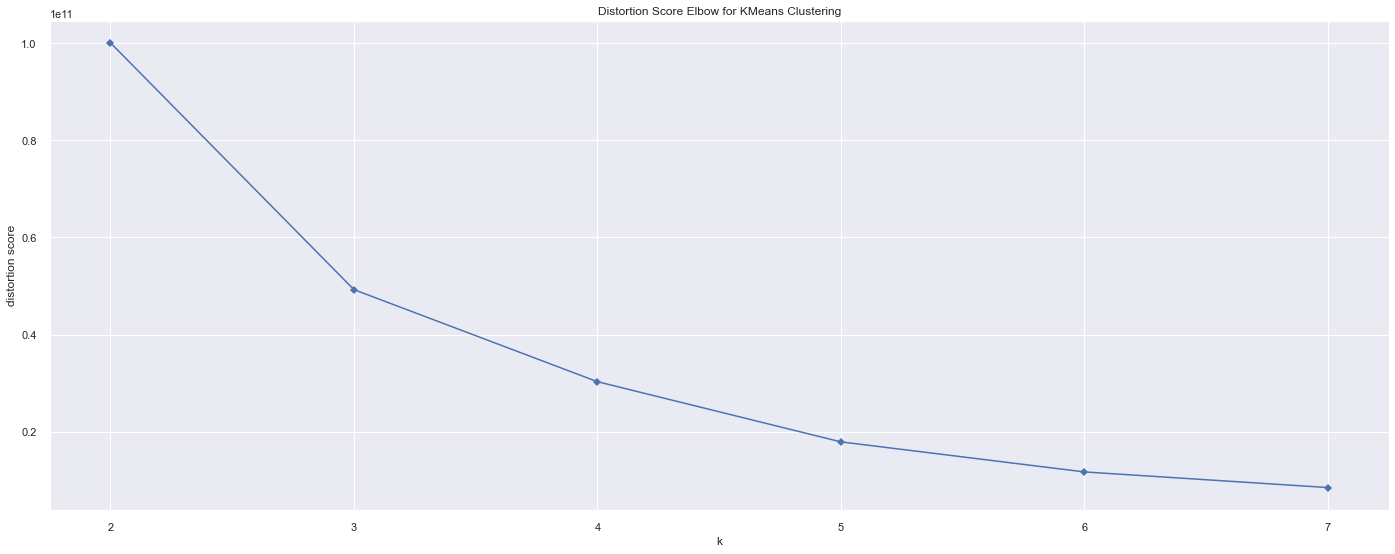

In [24]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,
                         timings=False )
kmeans.fit(X)
kmeans.show();

## 7.2 Sillhouette Score

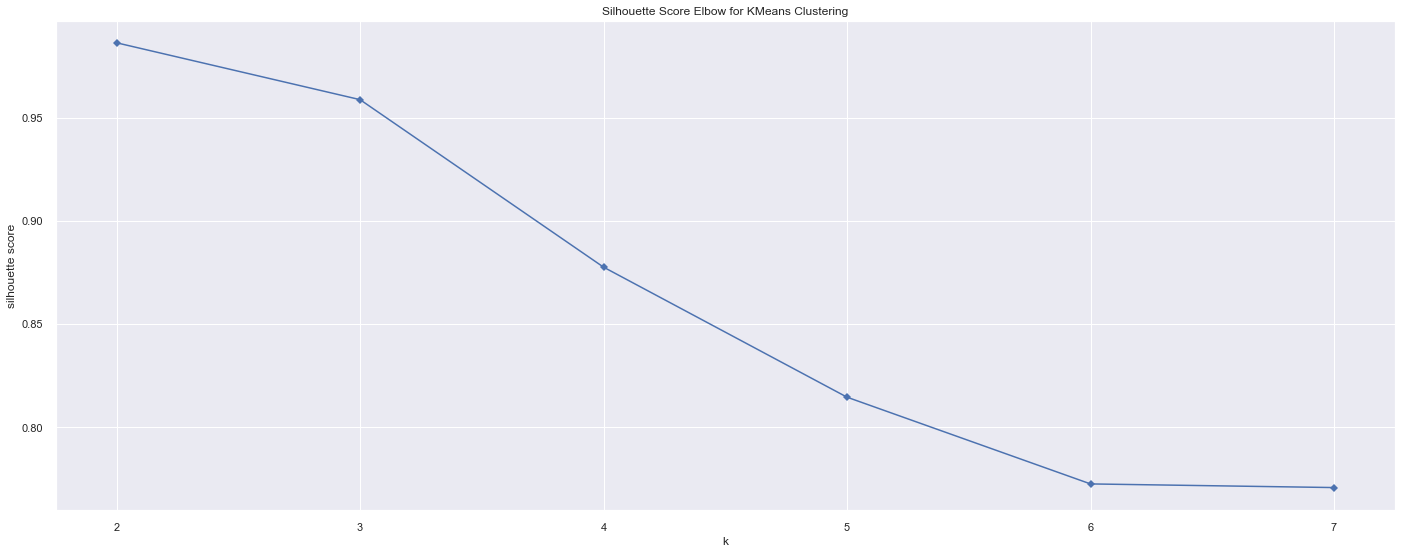

In [25]:
kmeans = KElbowVisualizer(c.KMeans(),
                         k=clusters,
                         metric='silhouette',
                         timings=False)
kmeans.fit(X)
kmeans.show()

## 7.3 Silhouette Analysis

Besides WSS and SS, the Silhouette Analysis allow us to make a better decision in which number of clusters to choose.

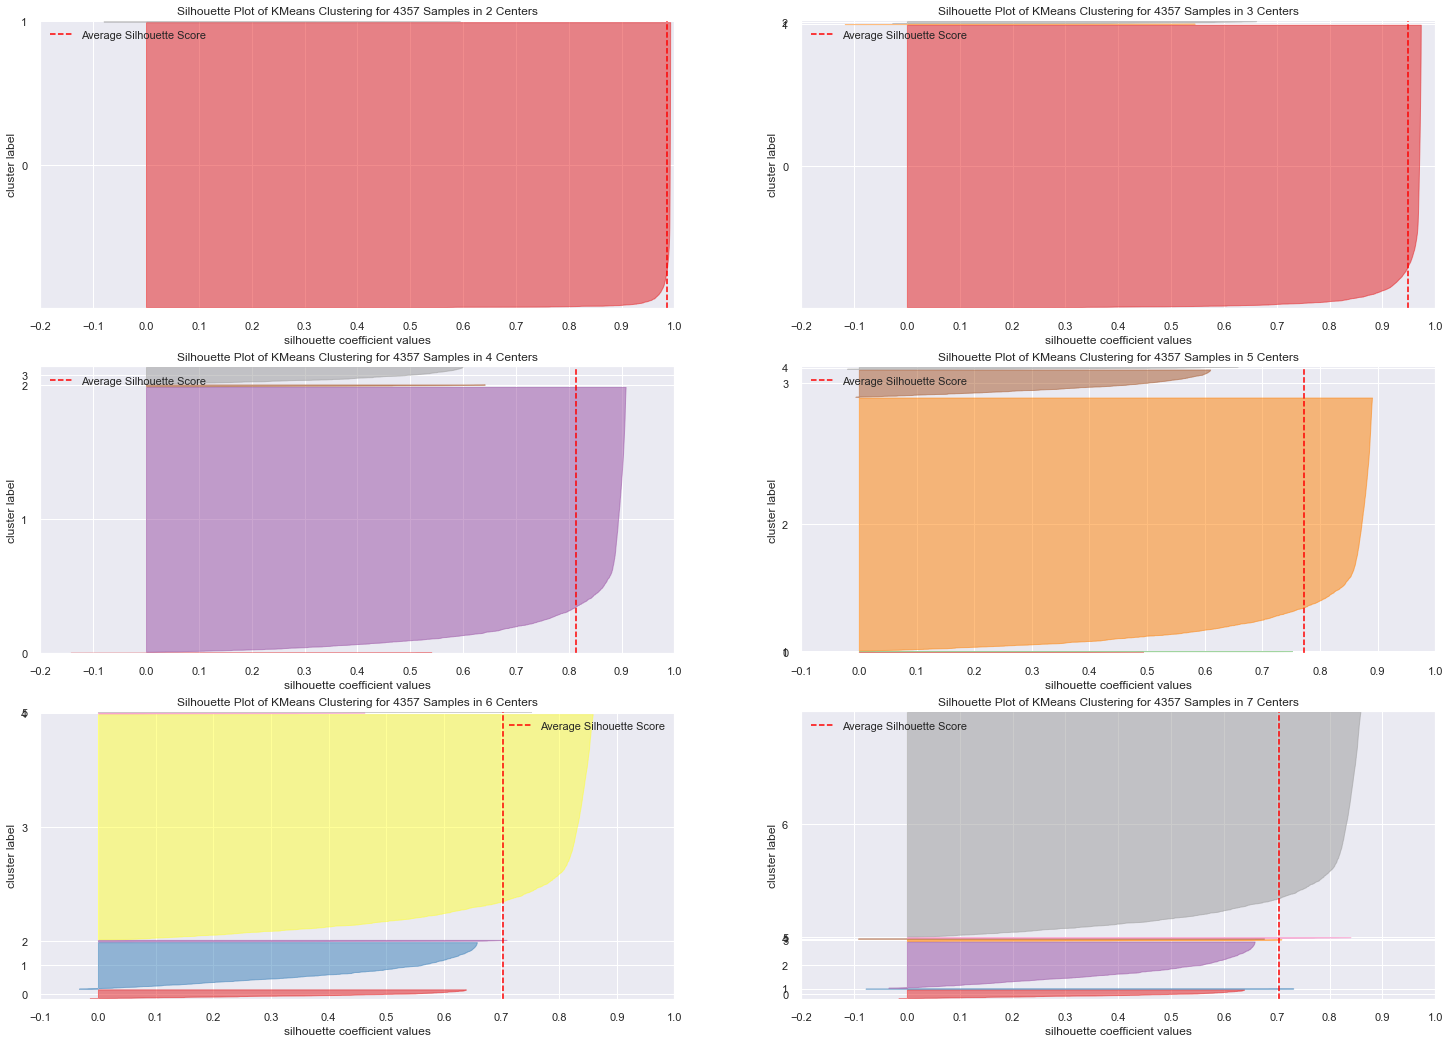

In [26]:
#7.1 Silhouette Analysis

fig, ax = plt.subplots(3,2,figsize=[25,18])
for k in clusters:
    km = c.KMeans(n_clusters=k, init='random',
                n_init=10,
                max_iter=100,
                random_state=42)
    q,mod = divmod(k,2)
    visualizer = SilhouetteVisualizer(km,colorts='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 Model Training

Bases on Silhoutte Score, we selected 2 clusters as the optimal number of k.

## 8.1 K-Means

In [27]:
# Model definition
k = 4
model_train = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Model Training
model_train.fit(X)

# Clustering
labels = model_train.labels_

## 8.2 Cluster Validation

In [28]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( model_train.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 40044031501.71544
SS value: 0.8137593295938614


# 9.0 Cluster Analysis

In [29]:
df9 =df6.copy() 

# Adding the clustes 
df9['cluster'] = labels

df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,1
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,1
4,15100,635.10,330,6,105.850000,1


## 9.1 Visualization Inspection

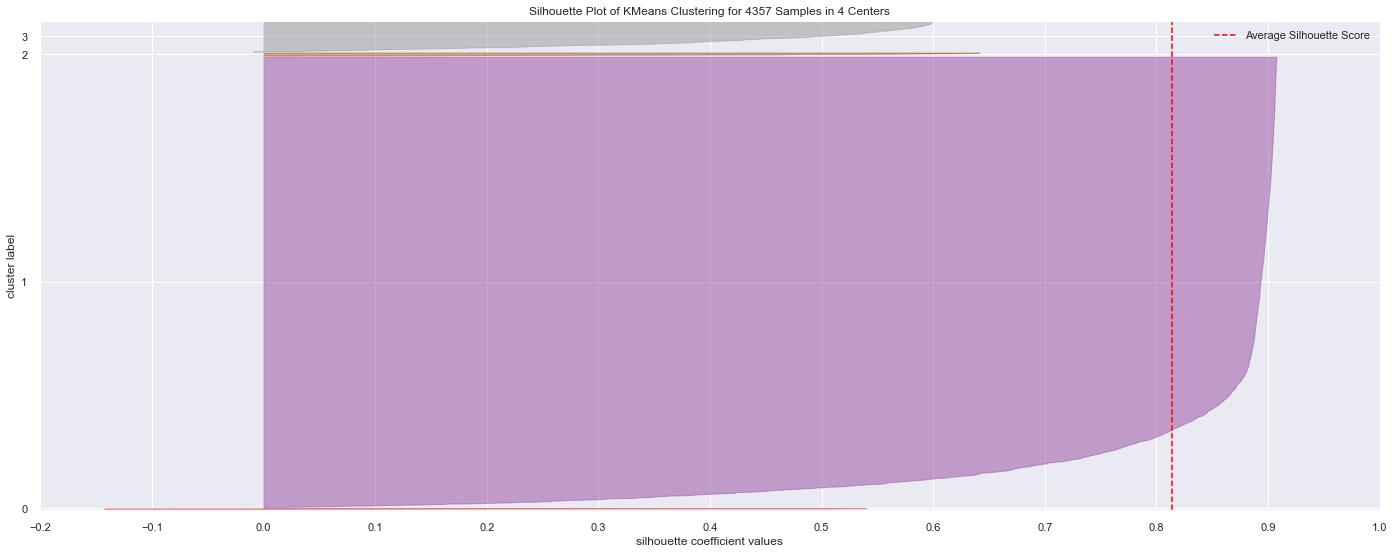

In [30]:
km = c.KMeans(n_clusters=k, init='random',
                n_init=10,
                max_iter=100,
                random_state=42)
visualizer = SilhouetteVisualizer(km,colorts='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2d Plot

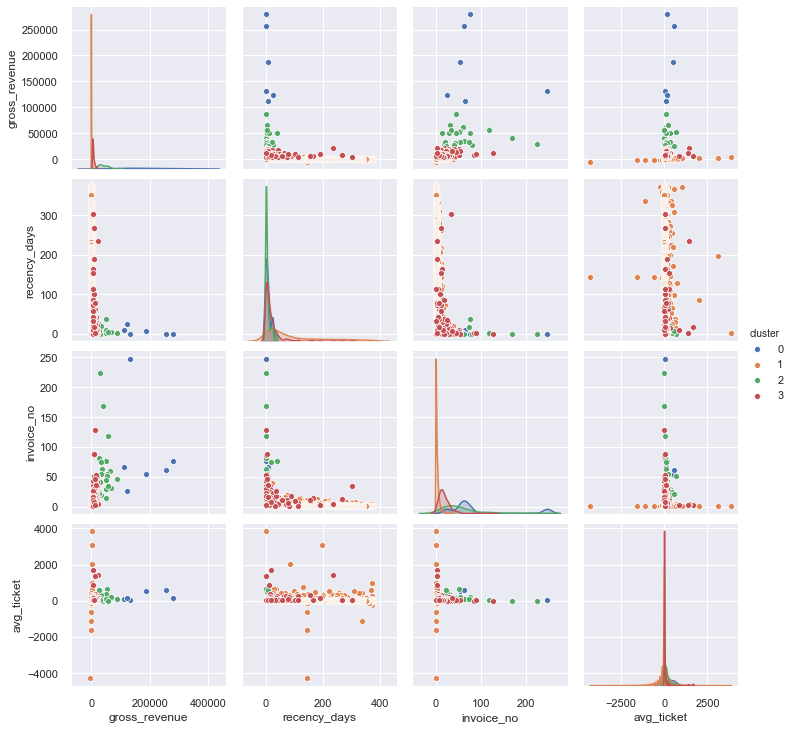

In [31]:
df_viz = df9.drop(columns='customer_id',axis=1)
sns.pairplot(df_viz, hue='cluster');

## 9.3 UMAP

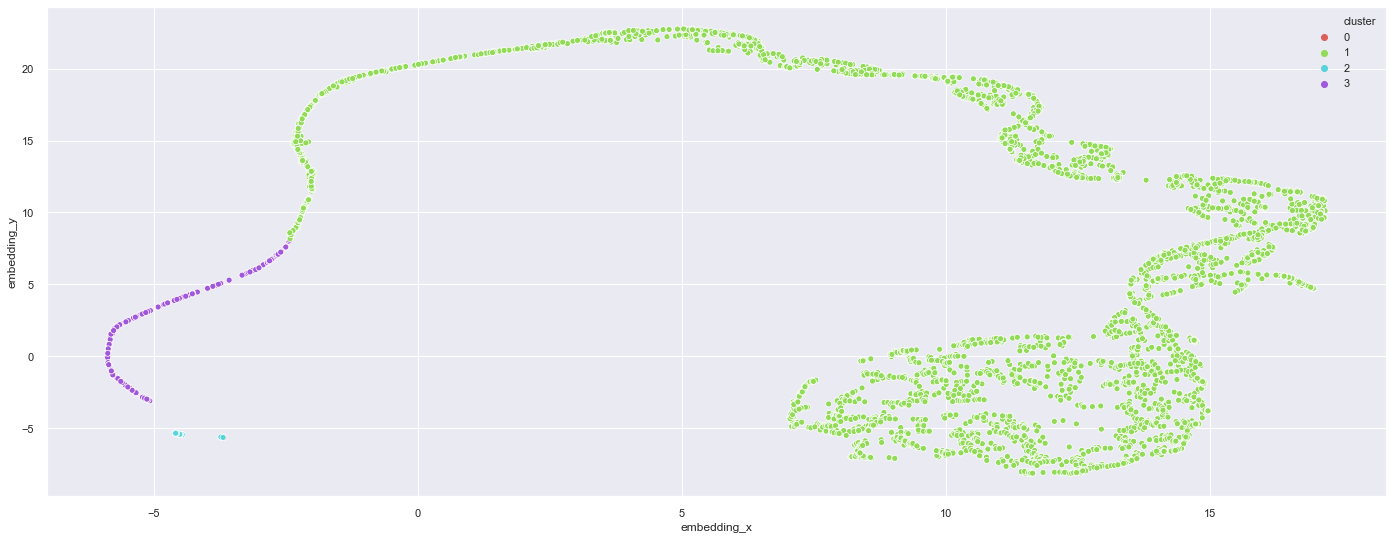

In [32]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot view
sns.scatterplot( x='embedding_x', y='embedding_y',
               hue='cluster', data=df_viz, palette=sns.color_palette('hls', n_colors=len(df_viz.cluster.unique())));


## 9.4 Cluster Profile

In [33]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Average Gross Revenue
df_avg_gross_rev = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_rev, how='inner',on='cluster')

# Average Recency Days
df_avg_rec_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_rec_days, how='inner',on='cluster')

# Average Invoice Number
df_avg_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner',on='cluster')

# Average Ticket 
df_avg_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner',on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,6,0.137709,182181.981667,7.166667,89.000000,253.626345
1,1,4056,93.091577,949.960289,96.998028,3.646943,25.350075
2,2,28,0.642644,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.128070,8089.028652,20.280899,19.528090,62.783157


# 10.0 Deploy